In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sn

# Hypothyroid Disease Classification
### Group 17: Matthew Gillies, Ryan Lee, Eric Liu

## EDA and Data Tidying

In [61]:
## Reading in data
hypothyroid_df = pd.read_csv("data/hypothyroid.csv")
hypothyroid_df.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,binaryClass
0,41,F,f,f,f,f,f,f,f,f,...,t,125,t,1.14,t,109,f,?,SVHC,P
1,23,F,f,f,f,f,f,f,f,f,...,t,102,f,?,f,?,f,?,other,P
2,46,M,f,f,f,f,f,f,f,f,...,t,109,t,0.91,t,120,f,?,other,P
3,70,F,t,f,f,f,f,f,f,f,...,t,175,f,?,f,?,f,?,other,P
4,70,F,f,f,f,f,f,f,f,f,...,t,61,t,0.87,t,70,f,?,SVI,P


In [62]:
hypothyroid_df.shape

(3772, 30)

In [21]:
## Replacing ? values with NA
hypothyroid = hypothyroid_df.replace("?", np.nan)

In [22]:
hypothyroid.isna().sum()

age                             1
sex                           150
on thyroxine                    0
query on thyroxine              0
on antithyroid medication       0
sick                            0
pregnant                        0
thyroid surgery                 0
I131 treatment                  0
query hypothyroid               0
query hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH measured                    0
TSH                           369
T3 measured                     0
T3                            769
TT4 measured                    0
TT4                           231
T4U measured                    0
T4U                           387
FTI measured                    0
FTI                           385
TBG measured                    0
TBG                          3772
referral source                 0
binaryClass   

In [42]:
## **** Not sure if we want to drop NA's or impute?
## Due to large amount of NA values in TBG and T3 these features will be removed from the dataset. 
## All "measured" features will also be removed as once NA's are removed they will all be "t"
## We will also removed the referral source column as it is quite irrelevant
## All other NA rows will simply be dropped
hypo = hypothyroid.drop(columns = ["TBG", "TBG measured", "T3", "T3 measured", "TSH measured", "TT4 measured", "FTI measured"
                                   , "T4U measured", "referral source"])

In [43]:
hypo_clean = hypo.dropna()

In [44]:
hypo_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3103 entries, 0 to 3771
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        3103 non-null   object
 1   sex                        3103 non-null   object
 2   on thyroxine               3103 non-null   object
 3   query on thyroxine         3103 non-null   object
 4   on antithyroid medication  3103 non-null   object
 5   sick                       3103 non-null   object
 6   pregnant                   3103 non-null   object
 7   thyroid surgery            3103 non-null   object
 8   I131 treatment             3103 non-null   object
 9   query hypothyroid          3103 non-null   object
 10  query hyperthyroid         3103 non-null   object
 11  lithium                    3103 non-null   object
 12  goitre                     3103 non-null   object
 13  tumor                      3103 non-null   object
 14  hypopitu

In [69]:
## Changing Dtype of the columns to numeric/categorical 
num_cols = ['age', 'TSH', 'TT4', 'T4U', 'FTI']
cat_cols = ['sex', 'on thyroxine', 'query on thyroxine', 'on antithyroid medication', 'sick', 'pregnant', 'thyroid surgery',
            'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium', 'goitre', 'tumor', 'psych', 'binaryClass',
           'hypopituitary']
hypo_clean[num_cols] = hypo_clean[num_cols].apply(pd.to_numeric, errors='coerce', axis=1)
for col in cat_cols:
    hypo_clean[col] = hypo_clean[col].astype('category')

/var/folders/h6/_rz_hgwd06q2j4rsml2mr9yr0000gn/T/ipykernel_71721/2488288775.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hypo_clean[num_cols] = hypo_clean[num_cols].apply(pd.to_numeric, errors='coerce', axis=1)
/var/folders/h6/_rz_hgwd06q2j4rsml2mr9yr0000gn/T/ipykernel_71721/2488288775.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hypo_clean[col] = hypo_clean[col].astype('category')
/var/folders/h6/_rz_hgwd06q2j4rsml2mr9yr0000gn/T/ipykernel_71721/2488288775.py:8: SettingWithCopyWarning: 
A valu

In [70]:
hypo_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3103 entries, 0 to 3771
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   age                        3103 non-null   float64 
 1   sex                        3103 non-null   category
 2   on thyroxine               3103 non-null   category
 3   query on thyroxine         3103 non-null   category
 4   on antithyroid medication  3103 non-null   category
 5   sick                       3103 non-null   category
 6   pregnant                   3103 non-null   category
 7   thyroid surgery            3103 non-null   category
 8   I131 treatment             3103 non-null   category
 9   query hypothyroid          3103 non-null   category
 10  query hyperthyroid         3103 non-null   category
 11  lithium                    3103 non-null   category
 12  goitre                     3103 non-null   category
 13  tumor                      3103 n

Figure 1: Correlations of numeric features


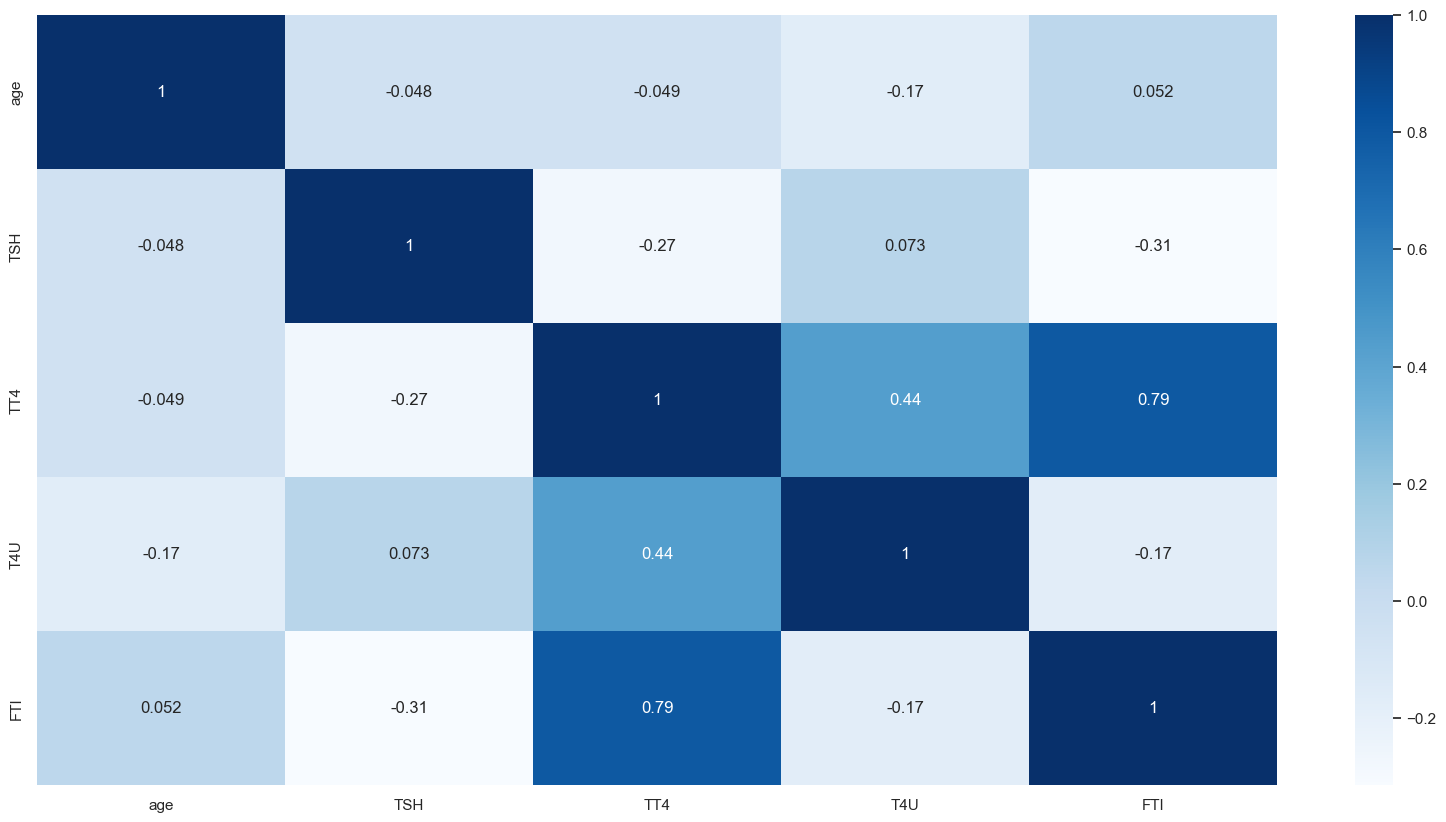

In [78]:
## Visualizing correlations of numeric features
print("Figure 1: Correlations of numeric features")
numeric = hypo_clean[['age', 'TSH', 'TT4', 'T4U', 'FTI']]
cor = numeric.corr()
plt.figure(figsize=(20, 10))
sn.set(font_scale=1)
sn.heatmap(cor, annot=True, cmap=plt.cm.Blues);

In [77]:
print("Figure 2: Realization of class counts")
pd.DataFrame(hypo_clean['binaryClass'].value_counts())

Figure 2: Realization of class counts


,binaryClass
P,2845
N,258
